In [ ]:
# --- Imports ---
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from player_setup import generate_players
from auction import Auction

# Ensure plots render inline
%matplotlib inline


In [ ]:
# --- Simulation Configuration ---

slow_speed_ranges = [(0.0, 0.6)]
fast_speed_ranges = [(0.4, 1.0)]

slow_bid_means = [round(x, 1) for x in np.arange(0.1, 1.0, 0.1)]
fast_bid_means = [round(x, 1) for x in np.arange(0.1, 1.0, 0.1)]
bid_range_width = 0.1

num_slow = 5
num_fast = 5
num_rounds = 1000000  


In [ ]:
# --- Run Simulations ---

results = []

for slow_speed, fast_speed, slow_mean, fast_mean in itertools.product(
    slow_speed_ranges, fast_speed_ranges, slow_bid_means, fast_bid_means
):
    players = generate_players(
        num_players=num_slow + num_fast,
        num_reactive=num_fast,
        gaussian_speed_min_range=slow_speed,
        gaussian_speed_max_range=slow_speed,
        gaussian_bid_prop_mean_range=(slow_mean, slow_mean),
        gaussian_bid_prop_std_range=(bid_range_width, bid_range_width),
        reactive_speed_min_range=fast_speed,
        reactive_speed_max_range=fast_speed,
        reactive_bid_prop_mean_range=(fast_mean, fast_mean),
        reactive_bid_prop_std_range=(bid_range_width, bid_range_width),
        reactive_others_mean_range=(slow_mean, slow_mean),
        reactive_others_std_range=(bid_range_width, bid_range_width)
    )

    auction = Auction(players, cutoff_time_range=(0.9, 1.0))
    round_results, winnings = auction.run_simulation(num_rounds)

    fast_ids = [p.player_id for p in players if "Reactive" in str(type(p))]
    slow_ids = [p.player_id for p in players if p.player_id not in fast_ids]

    fast_profits = [winnings[i] for i in fast_ids]
    slow_profits = [winnings[i] for i in slow_ids]
    fast_wins = sum(1 for r in round_results if r['winner'] and r['winner'][0] in fast_ids)
    slow_wins = sum(1 for r in round_results if r['winner'] and r['winner'][0] in slow_ids)

    total_fast_bids = total_fast_missed = total_slow_bids = total_slow_missed = 0
    for r in round_results:
        strategies = r["strategies"]
        cutoff = r["cutoff_time"]
        for pid in fast_ids:
            if strategies[pid][2] >= cutoff:
                total_fast_missed += 1
            total_fast_bids += 1
        for pid in slow_ids:
            if strategies[pid][2] >= cutoff:
                total_slow_missed += 1
            total_slow_bids += 1

    results.append({
        "slow_speed": slow_speed,
        "fast_speed": fast_speed,
        "slow_mean": slow_mean,
        "fast_mean": fast_mean,
        "fast_avg_profit": round(np.mean(fast_profits), 5),
        "slow_avg_profit": round(np.mean(slow_profits), 5),
        "fast_total_profit": round(sum(fast_profits), 5),
        "slow_total_profit": round(sum(slow_profits), 5),
        "fast_total_wins": fast_wins,
        "slow_total_wins": slow_wins,
        "fast_profit_per_win": round(sum(fast_profits) / fast_wins, 5) if fast_wins else 0,
        "slow_profit_per_win": round(sum(slow_profits) / slow_wins, 5) if slow_wins else 0,
        "fast_win_rate": round(fast_wins / num_rounds, 5),
        "slow_win_rate": round(slow_wins / num_rounds, 5),
        "fast_miss_rate": round(total_fast_missed / total_fast_bids, 5),
        "slow_miss_rate": round(total_slow_missed / total_slow_bids, 5)
    })

results_df = pd.DataFrame(results)
results_df.to_csv("strategy_grid__means_results.csv", index=False)
results_df.head()


,slow_speed,fast_speed,slow_mean,fast_mean,fast_avg_profit,slow_avg_profit,fast_total_profit,slow_total_profit,fast_total_wins,slow_total_wins,fast_profit_per_win,slow_profit_per_win,fast_win_rate,slow_win_rate,fast_miss_rate,slow_miss_rate
0,"(0.0, 0.6)","(0.4, 1.0)",0.1,0.1,57153.33092,82328.76090,285766.65461,411643.80452,791415,208585,0.36108,1.97351,0.79141,0.20858,0.00705,0.0
1,"(0.0, 0.6)","(0.4, 1.0)",0.1,0.2,77297.38017,57584.93142,386486.90085,287924.65709,863362,136638,0.44765,2.10721,0.86336,0.13664,0.02017,0.0
2,"(0.0, 0.6)","(0.4, 1.0)",0.1,0.3,75123.69256,50706.56171,375618.46282,253532.80853,945400,54600,0.39731,4.64346,0.94540,0.05460,0.00023,0.0
3,"(0.0, 0.6)","(0.4, 1.0)",0.1,0.4,46631.83079,70132.73879,233159.15396,350663.69394,978605,21395,0.23826,16.38998,0.97860,0.02140,0.01456,0.0
4,"(0.0, 0.6)","(0.4, 1.0)",0.1,0.5,86043.09539,22525.43720,430215.47695,112627.18600,989554,10446,0.43476,10.78185,0.98955,0.01045,0.02060,0.0


In [4]:
# --- Load Data for Visualization ---
df = pd.read_csv("strategy_grid_results.csv")
df["slow_speed"] = df["slow_speed"].apply(eval)
df["fast_speed"] = df["fast_speed"].apply(eval)


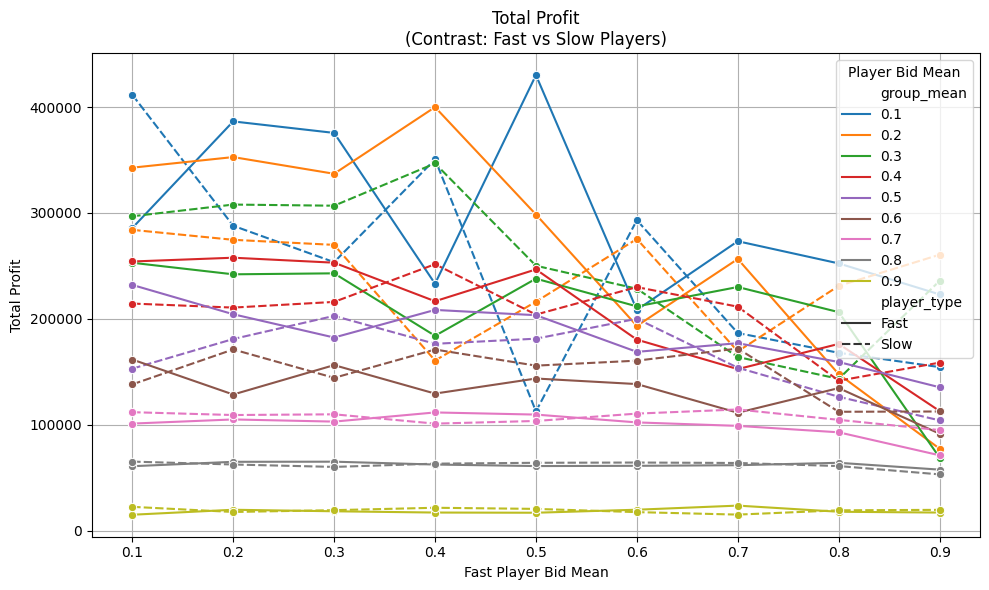

In [17]:
profit_df = pd.concat([
    df[["fast_mean", "slow_mean", "slow_total_profit"]].rename(columns={"slow_total_profit": "total_profit", "slow_mean": "group_mean"}).assign(player_type="Slow"),
    df[["fast_mean", "slow_mean", "fast_total_profit"]].rename(columns={"fast_total_profit": "total_profit", "slow_mean": "group_mean"}).assign(player_type="Fast")
])
profit_df = profit_df.groupby(["fast_mean", "group_mean", "player_type"], as_index=False).mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=profit_df, x="fast_mean", y="total_profit", hue="group_mean", style="player_type", marker="o", palette="tab10")
plt.title("Total Profit\n(Contrast: Fast vs Slow Players)")
plt.xlabel("Fast Player Bid Mean")
plt.ylabel("Total Profit")
plt.legend(title="Player Bid Mean")
plt.grid(True)
plt.tight_layout()
plt.savefig("mean_grid_total_profit_comparison.png")
plt.show()

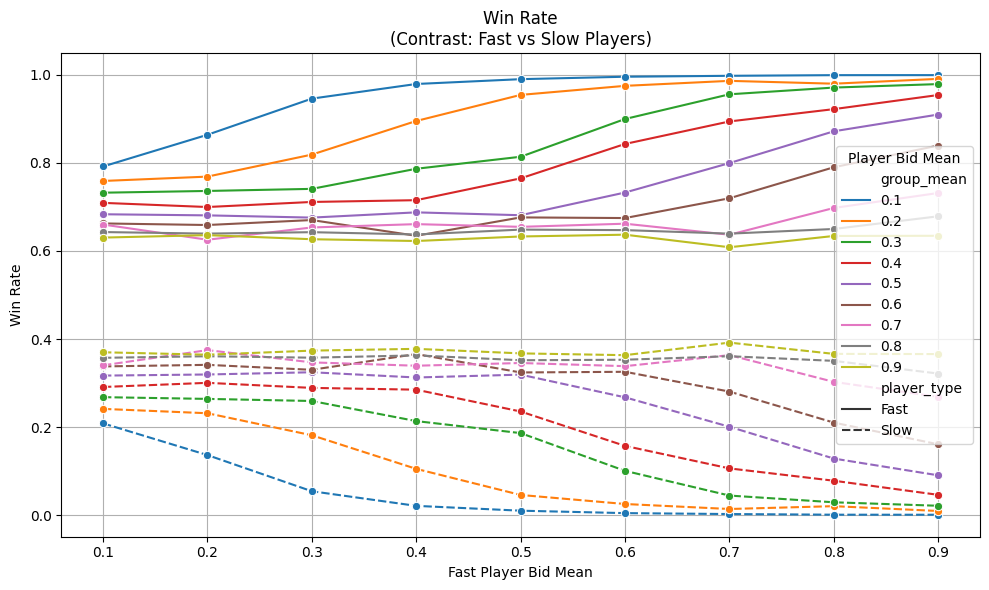

In [15]:
winrate_df = pd.concat([
    df[["fast_mean", "slow_mean", "slow_win_rate"]].rename(columns={"slow_win_rate": "win_rate", "slow_mean": "group_mean"}).assign(player_type="Slow"),
    df[["fast_mean", "slow_mean", "fast_win_rate"]].rename(columns={"fast_win_rate": "win_rate", "slow_mean": "group_mean"}).assign(player_type="Fast")
])
winrate_df = winrate_df.groupby(["fast_mean", "group_mean", "player_type"], as_index=False).mean()

plt.figure(figsize=(10, 6))
sns.lineplot(data=winrate_df, x="fast_mean", y="win_rate", hue="group_mean", style="player_type", marker="o", palette="tab10")
plt.title("Win Rate\n(Contrast: Fast vs Slow Players)")
plt.xlabel("Fast Player Bid Mean")
plt.ylabel("Win Rate")
plt.legend(title="Player Bid Mean")
plt.grid(True)
plt.tight_layout()
plt.savefig("mean_grid_winrate_comparison.png")
plt.show()